## MovieLens 20M Dataset Recommender System - 03_Modeling

This dataset describes 5-star rating and free-text tagging activity from [MovieLens](http://movielens.org), a movie recommendation service. These data were created by users between January 09, 1995 and March 31, 2015. This dataset was generated on March 31, 2015, and updated on October 17, 2016 to update links.csv and add genome-* files. 

Users were selected at random for inclusion. All selected users had rated at least 20 movies. No demographic information is included. Each user is represented by an id, and no other information is provided,

The data are contained in six files, 'genome-scores.csv', 'genome-tags.csv', 'links.csv', 'movies.csv', 'ratings.csv' and 'tags.csv'.

We would like to use it to build a model of recommender systems.

This is the final part of the study: Modeling.

### Content
### 1. Import Modules and Read Data File

### 1. Import Modules and Read Data File

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [17]:
from surprise import Reader, SVDpp, Dataset, accuracy
from surprise.model_selection import train_test_split, cross_validate

In [3]:
import recmetrics

In [4]:
# First, read the rating file.
ratings = pd.read_csv('./ml-20m/new_ratings.csv')

In [5]:
# remove ratings smaller than 3.5
ratings = ratings[ratings['rating']>=3.5]

In [7]:
ratings.head()

,userId,movieId,rating,rating_year,title,genres
1,73,55,5.0,2000,Georgia (1995),Drama
2,73,110,5.0,2000,Braveheart (1995),Action|Drama|War
3,73,111,4.0,2000,Taxi Driver (1976),Crime|Drama|Thriller
4,73,246,4.0,2000,Hoop Dreams (1994),Documentary
6,73,318,5.0,2000,"Shawshank Redemption, The (1994)",Crime|Drama


In [8]:
ratings.shape

(315200, 6)

C:\Users\cheng\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


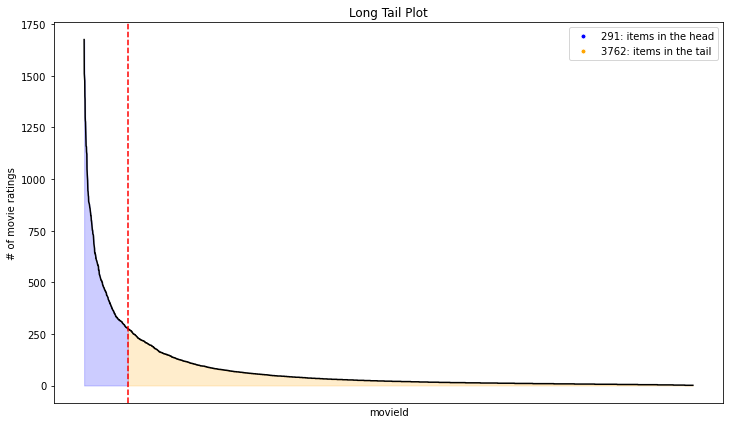

In [9]:
# Create long tail plot
fig = plt.figure(figsize=(12, 7))
recmetrics.long_tail_plot(df=ratings, 
             item_id_column="movieId", 
             interaction_type="movie ratings", 
             percentage=0.5,
             x_labels=False)

### 2. Use SVD++ Model to Predict the Rate

In [10]:
# All models in surprise use a special data type. First we need to convert the pandas dataframe to that special type.
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(0, 5))

# The columns must correspond to user id, item id and ratings (in that order).
new_ratings = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [11]:
# split the rating into train data and test data
trainset, testset = train_test_split(new_ratings, test_size=.10)

In [12]:
# create the SVD++ model 
svdpp = SVDpp()

In [13]:
# Fit the model
svdpp.fit(trainset)

In [18]:
print('The RMSE for the rating prediction is: ', accuracy.rmse(svdpp.test(testset)))

RMSE: 0.4322
The RMSE for the rating prediction is:  0.4321821534164485


In [19]:
# predict the rating in the test data
predictions = pd.DataFrame(svdpp.test(testset))

In [20]:
predictions.head()

,uid,iid,r_ui,est,details
0,82034,4489,4.5,3.887821,{'was_impossible': False}
1,88828,3477,4.0,4.324178,{'was_impossible': False}
2,69343,3129,5.0,4.617660,{'was_impossible': False}
3,74962,3897,4.0,4.103698,{'was_impossible': False}
4,97284,3361,3.5,3.889136,{'was_impossible': False}


In [21]:
# drop column and rename columns 
predictions.drop("details", inplace=True, axis=1)
predictions.columns = ['userId', 'movieId', 'actual', 'cf_predictions']

In [115]:
predictions.head()

,userId,movieId,actual,cf_predictions
0,82034,4489,4.5,3.887821
1,88828,3477,4.0,4.324178
2,69343,3129,5.0,4.617660
3,74962,3897,4.0,4.103698
4,97284,3361,3.5,3.889136


### 3. Make Various Recommendations to Users in Test Data

#### 3.1 Make Collaborative Filtering Recommendation

In [162]:
# create the recommendation matrix
recommended_movies = predictions.copy().groupby('userId', as_index=False)['movieId'].agg({'actual': (lambda x: list(set(x)))})

In [163]:
recommended_movies.head()

,userId,actual
0,73,"[1187, 3684, 3174, 1228, 3668, 1276]"
1,238,"[2336, 260, 2599, 1961, 3949, 1230, 527, 2329,..."
2,280,"[973, 1103, 4880, 1747, 950, 3742]"
3,283,"[3363, 1189, 1127, 141, 500, 1079, 507]"
4,344,"[3298, 6, 2502, 3178, 4973, 2128, 4881, 3538, ..."


In [159]:
# create prediction pivot table
cf_model = predictions.pivot_table(index='userId', columns='movieId', values='cf_predictions').fillna(0)

In [160]:
# define recommendation function
def get_users_recommendations(user_id, n, model):
    recommended_items = pd.DataFrame(model.loc[user_id])
    recommended_items.columns = ["predicted_rating"]
    recommended_items = recommended_items.sort_values('predicted_rating', ascending=False)    
    recommended_items = recommended_items.head(n)
    return recommended_items.index.tolist()

In [164]:
# set userId as index
recommended_movies = recommended_movies.set_index('userId')

In [165]:
recommended_movies.head()

,actual
userId,
73,"[1187, 3684, 3174, 1228, 3668, 1276]"
238,"[2336, 260, 2599, 1961, 3949, 1230, 527, 2329,..."
280,"[973, 1103, 4880, 1747, 950, 3742]"
283,"[3363, 1189, 1127, 141, 500, 1079, 507]"
344,"[3298, 6, 2502, 3178, 4973, 2128, 4881, 3538, ..."


In [166]:
# recommendations from collaborative filtering model
cf_recs = []
for user in recommended_movies.index:
    cf_predictions = get_users_recommendations(user, 10, cf_model)
    cf_recs.append(cf_predictions)

In [167]:
# add collaborative filtering recommendations to the recommendation matrix
recommended_movies['cf_recommendations'] = cf_recs

In [168]:
recommended_movies.head()

,actual,cf_recommendations
userId,,
73,"[1187, 3684, 3174, 1228, 3668, 1276]","[1228, 1276, 3668, 1187, 3684, 3174, 7026, 700..."
238,"[2336, 260, 2599, 1961, 3949, 1230, 527, 2329,...","[858, 260, 527, 1230, 2329, 3949, 2336, 1307, ..."
280,"[973, 1103, 4880, 1747, 950, 3742]","[950, 3742, 1103, 973, 4880, 1747, 3, 7028, 70..."
283,"[3363, 1189, 1127, 141, 500, 1079, 507]","[1189, 1079, 3363, 1127, 507, 141, 500, 7034, ..."
344,"[3298, 6, 2502, 3178, 4973, 2128, 4881, 3538, ...","[4973, 2502, 4881, 6, 3129, 1747, 3178, 3298, ..."


#### 3.2 Make Popularity Recommendation

In [169]:
# make popularity recommendations for all users in the test data
popularity_recs = ratings.movieId.value_counts().head(10).index.tolist()

In [170]:
# recommendations from popularity
pop_recs = []
for user in recommended_movies.index:
    pop_predictions = popularity_recs
    pop_recs.append(pop_predictions)

In [171]:
# add popularity recommendations to the recommendation matrix
recommended_movies['pop_recommendations'] = pop_recs

In [172]:
recommended_movies.head()

,actual,cf_recommendations,pop_recommendations
userId,,,
73,"[1187, 3684, 3174, 1228, 3668, 1276]","[1228, 1276, 3668, 1187, 3684, 3174, 7026, 700...","[318, 260, 2571, 2858, 1196, 527, 858, 1210, 2..."
238,"[2336, 260, 2599, 1961, 3949, 1230, 527, 2329,...","[858, 260, 527, 1230, 2329, 3949, 2336, 1307, ...","[318, 260, 2571, 2858, 1196, 527, 858, 1210, 2..."
280,"[973, 1103, 4880, 1747, 950, 3742]","[950, 3742, 1103, 973, 4880, 1747, 3, 7028, 70...","[318, 260, 2571, 2858, 1196, 527, 858, 1210, 2..."
283,"[3363, 1189, 1127, 141, 500, 1079, 507]","[1189, 1079, 3363, 1127, 507, 141, 500, 7034, ...","[318, 260, 2571, 2858, 1196, 527, 858, 1210, 2..."
344,"[3298, 6, 2502, 3178, 4973, 2128, 4881, 3538, ...","[4973, 2502, 4881, 6, 3129, 1747, 3178, 3298, ...","[318, 260, 2571, 2858, 1196, 527, 858, 1210, 2..."


#### 3.3 Make Random Recommendation

In [175]:
# make random recommendation
random_recs = []
for user in recommended_movies.index:
    random_predictions = ratings.movieId.sample(10).values.tolist()
    random_recs.append(random_predictions)

In [176]:
# add random recommendations to the recommendation matrix
recommended_movies['random_recommendations'] = random_recs

In [177]:
recommended_movies.head()

,actual,cf_recommendations,pop_recommendations,random_recommendations
userId,,,,
73,"[1187, 3684, 3174, 1228, 3668, 1276]","[1228, 1276, 3668, 1187, 3684, 3174, 7026, 700...","[318, 260, 2571, 2858, 1196, 527, 858, 1210, 2...","[388, 81932, 4014, 1943, 6638, 6807, 2908, 112..."
238,"[2336, 260, 2599, 1961, 3949, 1230, 527, 2329,...","[858, 260, 527, 1230, 2329, 3949, 2336, 1307, ...","[318, 260, 2571, 2858, 1196, 527, 858, 1210, 2...","[2396, 7303, 2352, 5303, 10, 1228, 45186, 1036..."
280,"[973, 1103, 4880, 1747, 950, 3742]","[950, 3742, 1103, 973, 4880, 1747, 3, 7028, 70...","[318, 260, 2571, 2858, 1196, 527, 858, 1210, 2...","[8641, 4351, 1648, 762, 260, 442, 1213, 4231, ..."
283,"[3363, 1189, 1127, 141, 500, 1079, 507]","[1189, 1079, 3363, 1127, 507, 141, 500, 7034, ...","[318, 260, 2571, 2858, 1196, 527, 858, 1210, 2...","[1213, 1240, 4995, 247, 1036, 1923, 592, 733, ..."
344,"[3298, 6, 2502, 3178, 4973, 2128, 4881, 3538, ...","[4973, 2502, 4881, 6, 3129, 1747, 3178, 3298, ...","[318, 260, 2571, 2858, 1196, 527, 858, 1210, 2...","[7263, 3872, 6942, 2300, 32139, 1513, 912, 191..."


#### 3.4 Make Parallel Recommendation

Youtube provides recommendations of "other people who watched this movie also watch:". Basically Youtube will recommend you with videos watched by other people who also watched your favorates. I think this is a great idea so I would like to do the same in this study.

Here is the procedure: for each user in the test data, find top five movies he/she rated the highest; then find the total rating on these five movies from each user in the rating file, and find 10 users who give highest total ratings. Then for each of the 10 users, find one movie he/she give highest rating. This movie should not be in the original top five movies. So we get one movie from each of the 10 users. We will then recommend these ten movies to the original user. We call this recommendation as "parallel recommendation".

We will repeat this procedure to every user in the test data.

In [43]:
# find all users in the rating file
users_in_rating = ratings['userId'].unique()

In [44]:
# find top five movies the user rated the highest
def find_top_rated_movies(user):
    return ratings[ratings['userId']==user].sort_values('rating', ascending=False)['movieId'].values[:5]

In [45]:
# find top 10 users who give highest total ratings on the five movies
def users_rated_highest_on_movies(user, movies):
    total_rating_value = []
    for u in users_in_rating:
        rating = 0.0
        for movie in movies:
            rating = rating + find_rating(u, movie)
        if u!=user:
            total_rating_value.append(rating)
    
    user_list = list(users_in_rating)
    user_list.remove(user)
#        print('user:', user)
#        print('rating:', rating)
#    print (len(users_in_train))
#    print(total_rating_value)
    rating_df = pd.DataFrame({'userId':user_list, 'total_rating': total_rating_value})
    rating_df = rating_df.sort_values('total_rating', ascending=False, ignore_index=True)
    return rating_df.loc[:10,'userId'], rating_df.loc[:10,'total_rating']

In [46]:
# find a movie a user give highest score. The movie should be excluded in the 'movies'
def recommend_movie(user, movies):
    movies_watched = ratings[ratings['userId']==user].sort_values('rating', ascending=False)['movieId'].values
    for movie in movies_watched:
        if movie not in movies:
            return movie

In [47]:
# find the rating of a user on a movie in the rating file
def find_rating(user, movie):
    users_watched = ratings[ratings['movieId']==movie]['userId'].unique()
    if user in users_watched:
        return ratings[(ratings['movieId']==movie)&(ratings['userId']==user)]['rating'].values[0]
    else:
        return 0.0

In [195]:
parallel_recs = []                # list to store recommended movies  
for i in range(len(recommended_movies.index)):      # for each user in the test data
    if(i%100)==0: print('i = ', i)                # print i when i = 100, 200, ... so that we know the instant iteration status
    user = recommended_movies.index[i]
    five_top_rated_movies = find_top_rated_movies(user)     # return 5 top rated movies
#    print('five top rated movieId', five_top_rated_movies)
#    print('five top rated movies', movie_title[movie_title.index.isin(five_top_rated_movies)]['title'])
    users, scores = users_rated_highest_on_movies(user, five_top_rated_movies)    # find 10 users who give highest total score
#    print('users:', users)
#    print('ratings', scores)
    recommended = []     # list to store recommended movies for this user
    for u in users:
        rec_movie = recommend_movie(u, five_top_rated_movies)   # find a movie the user give. the movie should not be in the 5 movies
        recommended.append(rec_movie)
    parallel_recs.append(list(set(recommended)))   # we see repeat movies in the recommendation. remove duplicates.
#    print('total rec movieId:', total_rec_movies)
#    print('total rec movies:', movie_title[movie_title.index.isin(total_rec_movies[0])]['title'])
#    print('\n')

i =  0
i =  100
i =  200
i =  300
i =  400
i =  500
i =  600
i =  700
i =  800
i =  900
i =  1000
i =  1100
i =  1200
i =  1300
i =  1400
i =  1500
i =  1600
i =  1700
i =  1800
i =  1900
i =  2000
i =  2100
i =  2200
i =  2300


In [196]:
# add parallel recommendations to the recommendation matrix
recommended_movies['parallel_recommendations'] = parallel_recs

In [197]:
recommended_movies.head()

,actual,cf_recommendations,pop_recommendations,random_recommendations,parallel_recommendations,unrated_recommendations
userId,,,,,,
73,"[1187, 3684, 3174, 1228, 3668, 1276]","[1228, 1276, 3668, 1187, 3684, 3174, 7026, 700...","[318, 260, 2571, 2858, 1196, 527, 858, 1210, 2...","[388, 81932, 4014, 1943, 6638, 6807, 2908, 112...","[1217, 36, 6, 7, 2247, 4970, 3789, 912, 6385, ...","[26150, 3736, 2920, 6669, 670, 7502, 77658, 37..."
238,"[2336, 260, 2599, 1961, 3949, 1230, 527, 2329,...","[858, 260, 527, 1230, 2329, 3949, 2336, 1307, ...","[318, 260, 2571, 2858, 1196, 527, 858, 1210, 2...","[2396, 7303, 2352, 5303, 10, 1228, 45186, 1036...","[3424, 1280, 1923, 293, 7, 3911, 3246, 8910, 2...","[670, 3739, 26150, 2920, 7502, 3736, 6669, 776..."
280,"[973, 1103, 4880, 1747, 950, 3742]","[950, 3742, 1103, 973, 4880, 1747, 3, 7028, 70...","[318, 260, 2571, 2858, 1196, 527, 858, 1210, 2...","[8641, 4351, 1648, 762, 260, 442, 1213, 4231, ...","[1218, 515, 5989, 2278, 6985, 2959, 1939, 3967...","[26094, 858, 3739, 25805, 6643, 1221, 3232, 49..."
283,"[3363, 1189, 1127, 141, 500, 1079, 507]","[1189, 1079, 3363, 1127, 507, 141, 500, 7034, ...","[318, 260, 2571, 2858, 1196, 527, 858, 1210, 2...","[1213, 1240, 4995, 247, 1036, 1923, 592, 733, ...","[4995, 2858, 1227, 1036, 909, 1196, 337, 8596,...","[26150, 77658, 670, 6669, 2920, 3736, 7502, 68..."
344,"[3298, 6, 2502, 3178, 4973, 2128, 4881, 3538, ...","[4973, 2502, 4881, 6, 3129, 1747, 3178, 3298, ...","[318, 260, 2571, 2858, 1196, 527, 858, 1210, 2...","[7263, 3872, 6942, 2300, 32139, 1513, 912, 191...","[994, 3, 1897, 1641, 1643, 1196, 3083, 592, 27...","[26150, 670, 77658, 6669, 6643, 7939, 6818, 44..."


#### 3.5 Make Unrated Recommendation

Basically recommendations should be restricted to the items the user has not used/watched. How can we know if one user will like/not like a movie he has not watched? Well, we already have a prediction algorithm. We can use it to predict the rating from any user/movie pair.

We call this recommendations on movies a user has not rated as "unrated recommendation".

Here is the precedure: for each user in the test data, find all movies he/she has not watched. Then we will create a new test set for the prediction. In this new set there are three columns: first column is about users in the (old) test set, second columnn is about the list of movies each user has not rated. third column is about the "actual rating". Since this data set is about movies user has not watched, there is no actual rating. We can just set all actual rating to be zero. This column is not useful for the modeling, but if we do not have this column, the algorithm does not work. So we will just have this column in our data. Our focus is on the predicted rating. 

In [51]:
# all movies in the rating file
movies_in_rating = ratings.movieId.unique()

In [52]:
predictions_unrated = []
for i in range(len(recommended_movies.index)):
    if(i%100)==0: print('i = ', i)
    user = recommended_movies.index[i]      # for each user in the test data
    movies_rated = ratings[ratings['userId']==user]['movieId']    # movies the user has rated
    movies_not_rated = list(set(movies_in_rating) - set(movies_rated))      # movies the user has not rated
    users_list = [user for i in range(len(movies_not_rated))]   # create a list with repeated user id
    user_movie_pair = []        # create a list to store user movie pair
    for i in range(len(users_list)):
        user_movie_pair.append(tuple([users_list[i], movies_not_rated[i], 0]))    # create a list of user, movie, dummy rating pair 
    pred = pd.DataFrame(svdpp.test(user_movie_pair))       # use our prediction algorithm to predict the rating
    pred = pred.sort_values('est', ascending=False)       # sort the data by the predicted rating value
    predictions_unrated.append(pred['iid'].head(10).tolist())    # return the ids of 10 movies with highest predicted rating

i =  0
i =  100
i =  200
i =  300
i =  400
i =  500
i =  600
i =  700
i =  800
i =  900
i =  1000
i =  1100
i =  1200
i =  1300
i =  1400
i =  1500
i =  1600
i =  1700
i =  1800
i =  1900
i =  2000
i =  2100
i =  2200
i =  2300


In [180]:
# add unrated recommendations to the recommendation matrix
recommended_movies['unrated_recommendations'] = predictions_unrated

In [181]:
recommended_movies.head()

,actual,cf_recommendations,pop_recommendations,random_recommendations,parallel_recommendations,unrated_recommendations
userId,,,,,,
73,"[1187, 3684, 3174, 1228, 3668, 1276]","[1228, 1276, 3668, 1187, 3684, 3174, 7026, 700...","[318, 260, 2571, 2858, 1196, 527, 858, 1210, 2...","[388, 81932, 4014, 1943, 6638, 6807, 2908, 112...","[5989, 6, 2396, 6, 26400, 1923, 1680, 1280, 39...","[26150, 3736, 2920, 6669, 670, 7502, 77658, 37..."
238,"[2336, 260, 2599, 1961, 3949, 1230, 527, 2329,...","[858, 260, 527, 1230, 2329, 3949, 2336, 1307, ...","[318, 260, 2571, 2858, 1196, 527, 858, 1210, 2...","[2396, 7303, 2352, 5303, 10, 1228, 45186, 1036...","[113573, 7, 6, 11, 6, 1704, 51678, 1358, 4119,...","[670, 3739, 26150, 2920, 7502, 3736, 6669, 776..."
280,"[973, 1103, 4880, 1747, 950, 3742]","[950, 3742, 1103, 973, 4880, 1747, 3, 7028, 70...","[318, 260, 2571, 2858, 1196, 527, 858, 1210, 2...","[8641, 4351, 1648, 762, 260, 442, 1213, 4231, ...","[26400, 3703, 3148, 6, 1535, 2313, 1225, 11357...","[26094, 858, 3739, 25805, 6643, 1221, 3232, 49..."
283,"[3363, 1189, 1127, 141, 500, 1079, 507]","[1189, 1079, 3363, 1127, 507, 141, 500, 7034, ...","[318, 260, 2571, 2858, 1196, 527, 858, 1210, 2...","[1213, 1240, 4995, 247, 1036, 1923, 592, 733, ...","[2336, 1307, 2028, 3789, 1649, 3265, 3083, 363...","[26150, 77658, 670, 6669, 2920, 3736, 7502, 68..."
344,"[3298, 6, 2502, 3178, 4973, 2128, 4881, 3538, ...","[4973, 2502, 4881, 6, 3129, 1747, 3178, 3298, ...","[318, 260, 2571, 2858, 1196, 527, 858, 1210, 2...","[7263, 3872, 6942, 2300, 32139, 1513, 912, 191...","[6, 1680, 2245, 11, 36, 3451, 2105, 6, 1649, 2...","[26150, 670, 77658, 6669, 6643, 7939, 6818, 44..."


### 4. Evaluation on Recommendations 

Let's plot MAR@K (Mean Average at K) on all those recommendations. 

In [182]:
actual = recommended_movies.actual.values.tolist()
cf_recommendations = recommended_movies.cf_recommendations.values.tolist()
pop_recommendations = recommended_movies.pop_recommendations.values.tolist()
random_recommendations = recommended_movies.random_recommendations.values.tolist()

In [183]:
parallel_recommendations = recommended_movies.parallel_recommendations.values.tolist()
unrated_recommendations = recommended_movies.unrated_recommendations.values.tolist()

In [184]:
pop_mark = []
for K in np.arange(1, 11):
    pop_mark.extend([recmetrics.mark(actual, pop_recommendations, k=K)])
pop_mark

[0.006716164998541742,
 0.00977819701706851,
 0.01173554961948596,
 0.01332046476376805,
 0.014607118714655951,
 0.01597363728795046,
 0.017145986815673146,
 0.018116093563273723,
 0.018883144486871565,
 0.019628975475493513]

In [185]:
random_mark = []
for K in np.arange(1, 11):
    random_mark.extend([recmetrics.mark(actual, random_recommendations, k=K)])
random_mark

[0.0013866957147521649,
 0.0021071941197973983,
 0.002544815562065726,
 0.002969639030637214,
 0.0033938162206193145,
 0.0035999112303333252,
 0.0038397709367983587,
 0.004041243071043648,
 0.00428958920324179,
 0.004434873226833337]

In [186]:
cf_mark = []
for K in np.arange(1, 11):
    cf_mark.extend([recmetrics.mark(actual, cf_recommendations, k=K)])
cf_mark

[0.12328020217075208,
 0.23849588821247192,
 0.34416148936454827,
 0.4393573678227932,
 0.523623704685113,
 0.5967694982537145,
 0.6589503795416143,
 0.7138550056755,
 0.7599523313000479,
 0.7973720489261049]

In [187]:
parallel_mark = []
for K in np.arange(1, 11):
    parallel_mark.extend([recmetrics.mark(actual, parallel_recommendations, k=K)])
parallel_mark

[0.0017035513132163573,
 0.002440948633907493,
 0.0029731404466217396,
 0.0033502321822396,
 0.00376763621024737,
 0.004062970567073618,
 0.00434032616608598,
 0.004558623327730415,
 0.004708007662366961,
 0.004872014262216497]

In [205]:
unrated_mark = []
for K in np.arange(1, 11):
    unrated_mark.extend([recmetrics.mark(actual, unrated_recommendations, k=K)])
unrated_mark

[0.00010299489066809292,
 0.00019974326116689646,
 0.0003017799678021008,
 0.0003785792232118899,
 0.00043366935326522054,
 0.0005119482561294542,
 0.0005836887823877732,
 0.0006558643254355574,
 0.0007039565563476428,
 0.0007764372867789586]

In [208]:
unrated_mark_2 = []
for K in np.arange(1, 11):
    unrated_mark_2.extend([recmetrics.mark(parallel_recommendations, unrated_recommendations, k=K)])
unrated_mark_2

[0.00046303441889180424,
 0.0008103102330606574,
 0.0010289653753151207,
 0.0012411894839738642,
 0.0014032515305859956,
 0.0016026135720533007,
 0.001790032265414269,
 0.0019492003469083266,
 0.00203066010578744,
 0.0021464187105103916]

In [206]:
mark_scores = [random_mark, pop_mark, cf_mark, parallel_mark, unrated_mark]
index = range(1,10+1)
names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter', 'Parallel Recommender', 'Unrated Recommender']

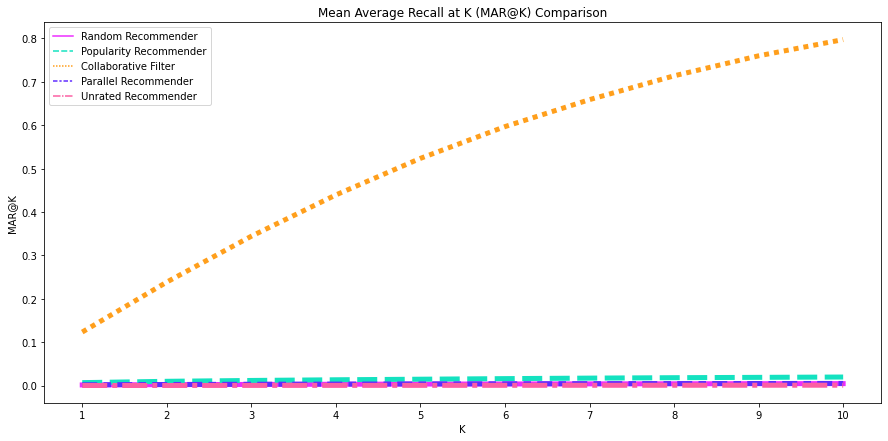

In [207]:
fig = plt.figure(figsize=(15, 7))
recmetrics.mark_plot(mark_scores, model_names=names, k_range=index)

Conclusion: 

To explain the mean average recall at K, first let's see what recall means. A recall is defined as total predicted true positive divided by true positive. Here positive could be defined as a rating greater than 3.5. If a user gives a movie higher than 3.5, we also call the movie is "relevant" to the user. 

Recall at k is the proportion of relevant items found in the top-k recommendations. So in the MAR@K plot, a large slope of one recommenders means that many relevant items were found by using the recommender. We can see that the slope of the collaborative filtering is much higher than the other slopes. This means that the prediction from the collaborative filtering recommends many relevant items. 

But this raises a big problem. A good recommender should recommend items the user has never used but might be interested to use, not items the user has already used and rated. So if we have an efficient recommender, we should use it to predict ratings by a user to items(movies) he or she has never watched, and recommend items with high predicted ratings to this user. Because these movies have not watched by the user, there is no actual rating, so these movies are not relevant to this user, although they have high predicted rating by a powerful algorithm which is proved to be quite successful.

In this study we use the SVD++ algorithm, which gives a RMSE of 0.43. This is believed to be quite low so we can say that the algorithm is successful. 

In the MAR@K plot, the slopes of the parallel recommender and the unrated recommender are quite flat. But we have confidence that both recommenders work well. This is because in the parallel recommenders we apply the idea "users who liked those movies also watched...", and in the unrated recommender, we use the SVD++ algorithm to predict ratings from movies a user has not rated, and recommend movies with high predicted ratings to this user. So although these two recommender give flat lines in the plot, we know they are useful to recommend movies that the users will most likely love. 